In [101]:
# %% [markdown]
# # Analisi Avanzata Risultati Performance - perf stat
# 
# Questo notebook analizza i risultati dei test di performance raccolti con `perf stat` per confrontare:
# - Implementazioni scalari vs vettoriali
# - Tre tipi di operazioni: **standard**, **elementwise**, **sparse**
# - Diverse dimensioni di vettori (4, 8, 16, 32)
# - Metriche di efficienza avanzate e correlazioni

# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
from pathlib import Path
import warnings
from scipy import stats
from itertools import combinations
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

warnings.filterwarnings('ignore')

# Configurazione per grafici più leggibili
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.labelsize'] = 10

# Colori consistenti per le operazioni
OPERATION_COLORS = {
    'standard': '#1f77b4',
    'elementwise': '#ff7f0e', 
    'sparse': '#2ca02c'
}

In [102]:
# %% [markdown]
# ## Funzioni di Utilità Migliorate

# %%
def parse_perf_csv(file_path):
    """
    Parsa un file CSV di perf stat e restituisce un DataFrame pulito
    con gestione migliorata degli errori e metadati più dettagliati
    """
    try:
        # Leggi il CSV con gestione robusta degli errori
        df = pd.read_csv(file_path, header=None, names=[
            'value', 'unit', 'event', 'percentage', 'time', 'enabled_time', 
            'rate', 'description'
        ], on_bad_lines='skip')
        
        # Pulisci e converti i valori numerici
        df['value'] = df['value'].astype(str).str.replace(',', '').str.replace('<not counted>', '0')
        df['value_numeric'] = pd.to_numeric(df['value'], errors='coerce')
        
        # Aggiungi metadati dal path del file
        path_parts = Path(file_path).parts
        df['file_name'] = Path(file_path).stem
        df['full_path'] = str(file_path)
        df['directory'] = path_parts[-2] if len(path_parts) > 1 else 'unknown'
        
        # Determina il tipo di test con logica migliorata
        path_str = str(file_path).lower()
        if 'scalar' in path_str:
            df['test_type'] = 'scalar'
            df['vector_size'] = 'N/A'
        else:
            df['test_type'] = 'vector'
            # Estrai la dimensione del vettore
            vector_size = 'unknown'
            for size in [4, 8, 16, 32]:
                if f'vector_{size}' in path_str:
                    vector_size = str(size)
                    break
            df['vector_size'] = vector_size
        
        # Determina il tipo di operazione con logica più robusta
        if 'elementwise' in path_str:
            df['operation_type'] = 'elementwise'
        elif 'sparse' in path_str:
            df['operation_type'] = 'sparse'
        else:
            df['operation_type'] = 'standard'
        
        # Aggiungi identificatore unico per il test
        df['test_id'] = f"{df['test_type'].iloc[0]}_{df['operation_type'].iloc[0]}_{df['vector_size'].iloc[0]}"
            
        return df
    except Exception as e:
        print(f"Errore nel parsing di {file_path}: {e}")
        return None

def load_all_perf_data(base_path='.'):
    """
    Carica tutti i file CSV con gestione migliorata dei pattern
    """
    all_data = []
    
    # Pattern più specifici per evitare duplicati
    patterns = [
        f"{base_path}/results_scalar/**/*.csv",
        f"{base_path}/results_vector/**/*.csv"
    ]
    
    file_count = 0
    for pattern in patterns:
        csv_files = glob.glob(pattern, recursive=True)
        print(f"Pattern '{pattern}': trovati {len(csv_files)} file CSV")
        
        for file_path in csv_files:
            df = parse_perf_csv(file_path)
            if df is not None and not df.empty:
                all_data.append(df)
                file_count += 1
    
    if all_data:
        combined_df = pd.concat(all_data, ignore_index=True)
        # Rimuovi duplicati basati su combinazioni di metadati
        combined_df = combined_df.drop_duplicates(subset=['file_name', 'event', 'test_type', 'operation_type', 'vector_size'])
        print(f"Caricati {len(combined_df)} record unici da {file_count} file")
        return combined_df
    else:
        print("Nessun dato caricato!")
        return pd.DataFrame()

def calculate_statistical_significance(df, metric, group1, group2, group_col='test_type'):
    """
    Calcola la significatività statistica tra due gruppi
    """
    data1 = df[(df[group_col] == group1) & (df['event'] == metric)]['value_numeric'].dropna()
    data2 = df[(df[group_col] == group2) & (df['event'] == metric)]['value_numeric'].dropna()
    
    if len(data1) > 1 and len(data2) > 1:
        statistic, p_value = stats.ttest_ind(data1, data2)
        return {
            'statistic': statistic,
            'p_value': p_value,
            'significant': p_value < 0.05,
            'mean_diff': data1.mean() - data2.mean(),
            'effect_size': (data1.mean() - data2.mean()) / np.sqrt((data1.var() + data2.var()) / 2)
        }
    return None

In [103]:
# %% [markdown]
# ## Caricamento e Validazione Dati

# %%
# Carica tutti i dati
df = load_all_perf_data()

# Validazione e pulizia dati
if not df.empty:
    print("="*60)
    print("DATASET CARICATO CON SUCCESSO")
    print("="*60)
    print(f"Forma del dataset: {df.shape}")
    print(f"Tipi di test: {sorted(df['test_type'].unique())}")
    print(f"Dimensioni vettori: {sorted(df[df['vector_size'] != 'N/A']['vector_size'].unique(), key=lambda x: int(x) if x.isdigit() else 0)}")
    print(f"Tipi di operazioni: {sorted(df['operation_type'].unique())}")
    print(f"Eventi misurati: {sorted(df['event'].unique())}")
    
    # Conta test per categoria
    print("\nDistribuzione test per categoria:")
    test_distribution = df.groupby(['test_type', 'operation_type', 'vector_size']).size().reset_index(name='count')
    for _, row in test_distribution.iterrows():
        print(f"  {row['test_type']:8s} | {row['operation_type']:12s} | Size {row['vector_size']:3s} | {row['count']:3d} metriche")
    
    # Verifica qualità dati
    print(f"\nQualità dati:")
    print(f"  Valori mancanti: {df['value_numeric'].isna().sum()}/{len(df)} ({df['value_numeric'].isna().mean()*100:.1f}%)")
    print(f"  Valori zero: {(df['value_numeric'] == 0).sum()}")
    print(f"  File unici: {df['file_name'].nunique()}")
    
else:
    print("ERRORE: Dataset vuoto. Verifica i percorsi dei file.")
    exit()

# %% [markdown]
# ## Preparazione Metriche Principali

# %%
# Metriche chiave con descrizioni
KEY_METRICS = {
    'task-clock': 'Tempo di esecuzione (ms)',
    'cycles': 'Cicli CPU totali',
    'instructions': 'Istruzioni eseguite',
    'branches': 'Branch totali',
    'branch-misses': 'Branch mancati',
    'cache-references': 'Accessi cache',
    'cache-misses': 'Cache miss',
}

# Filtra solo le metriche principali disponibili
available_metrics = [metric for metric in KEY_METRICS.keys() if metric in df['event'].values]
print(f"Metriche disponibili per l'analisi: {available_metrics}")

df_metrics = df[df['event'].isin(available_metrics)].copy()
print(f"Dataset filtrato: {len(df_metrics)} record con metriche principali")

Pattern './results_scalar/**/*.csv': trovati 93 file CSV
Pattern './results_vector/**/*.csv': trovati 372 file CSV
Caricati 3720 record unici da 465 file
DATASET CARICATO CON SUCCESSO
Forma del dataset: (3720, 16)
Tipi di test: ['scalar', 'vector']
Dimensioni vettori: ['4', '8', '16', '32']
Tipi di operazioni: ['elementwise', 'sparse', 'standard']
Eventi misurati: ['branch-misses', 'branches', 'context-switches', 'cpu-migrations', 'cycles', 'instructions', 'page-faults', 'task-clock']

Distribuzione test per categoria:
  scalar   | elementwise  | Size N/A | 248 metriche
  scalar   | sparse       | Size N/A | 248 metriche
  scalar   | standard     | Size N/A | 248 metriche
  vector   | elementwise  | Size 16  | 248 metriche
  vector   | elementwise  | Size 32  | 248 metriche
  vector   | elementwise  | Size 4   | 248 metriche
  vector   | elementwise  | Size 8   | 248 metriche
  vector   | sparse       | Size 16  | 248 metriche
  vector   | sparse       | Size 32  | 248 metriche
  vecto

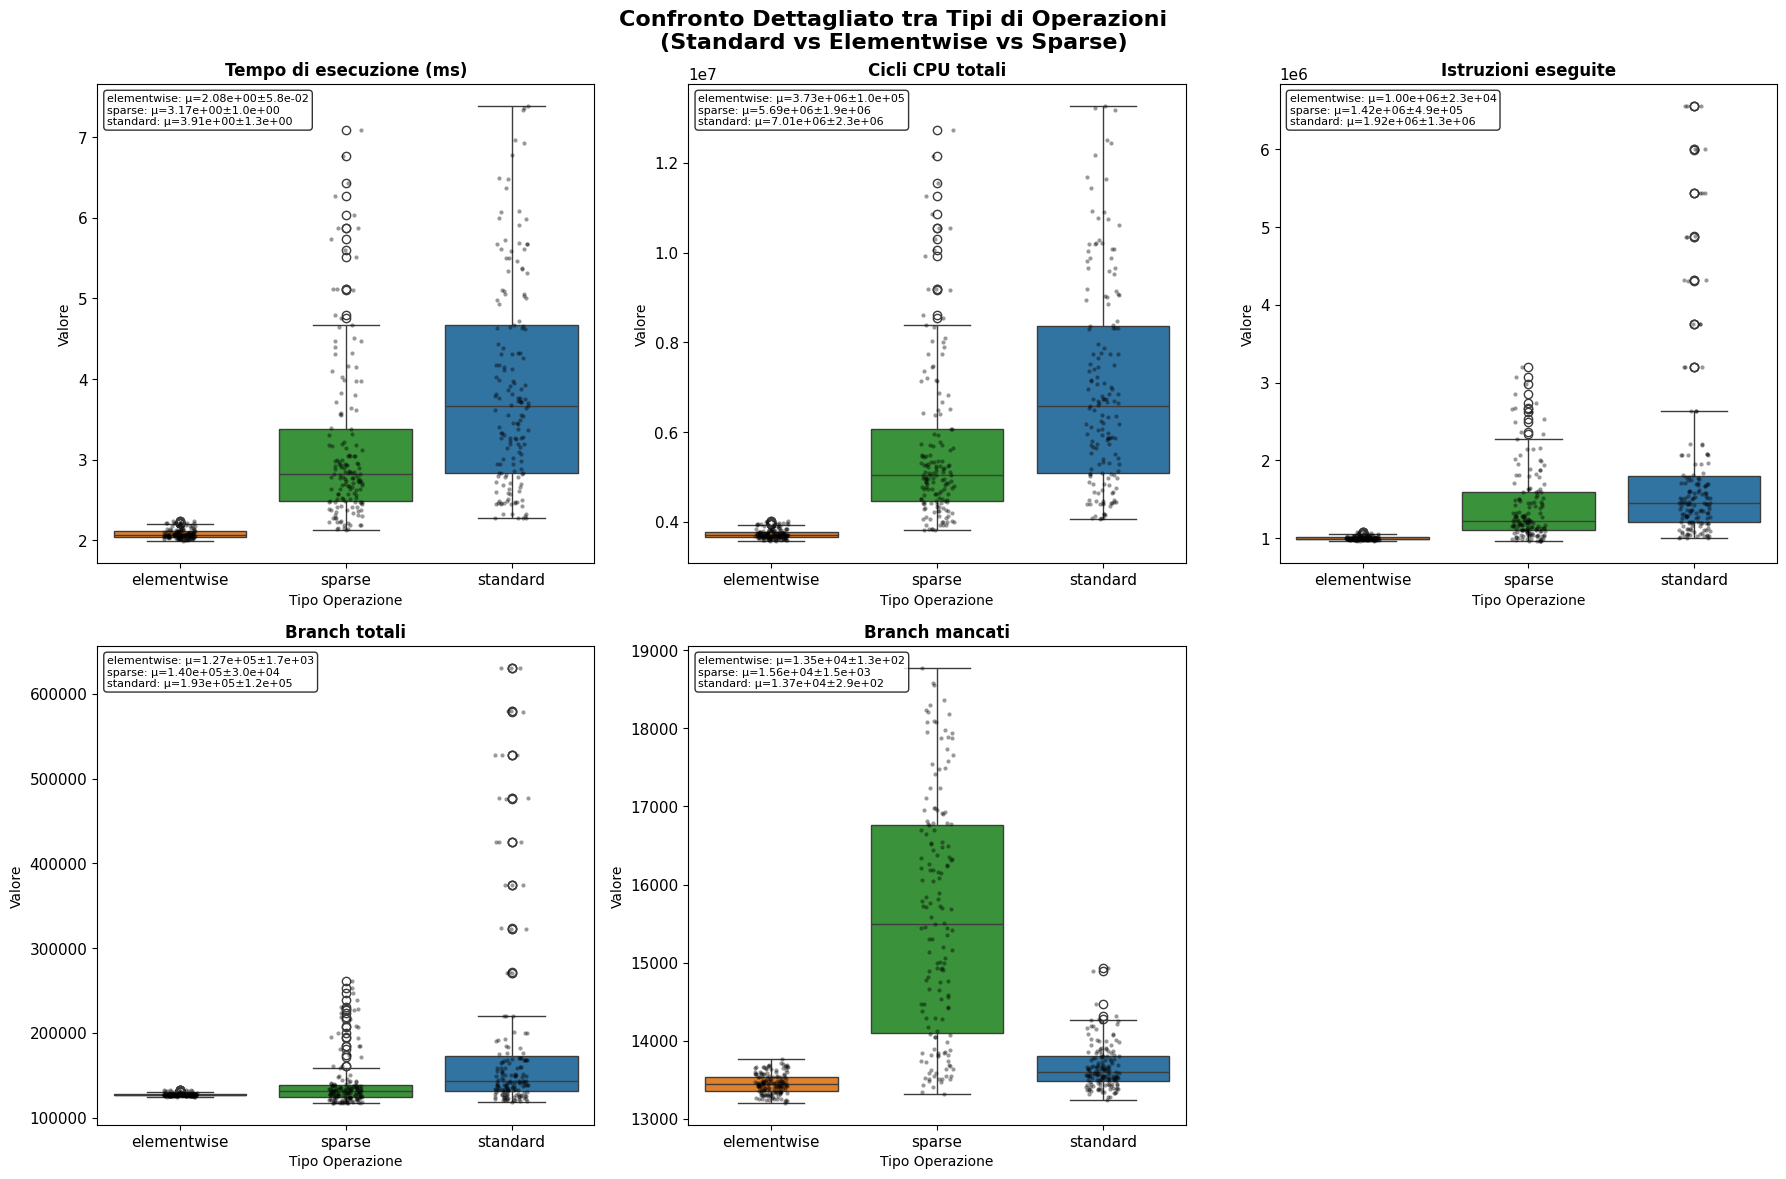

In [104]:
# %% [markdown]
# ## 1. ANALISI COMPARATIVA TRA TIPI DI OPERAZIONI

# %%
def create_operation_comparison_plots():
    """
    Crea grafici di confronto dettagliati tra i tre tipi di operazioni
    """
    if df_metrics.empty:
        print("Nessun dato disponibile per il confronto")
        return
    
    # Configura la griglia di subplot
    n_metrics = len(available_metrics)
    n_cols = 3
    n_rows = (n_metrics + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6*n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    fig.suptitle('Confronto Dettagliato tra Tipi di Operazioni\n(Standard vs Elementwise vs Sparse)', 
                 fontsize=16, fontweight='bold', y=0.98)
    
    for i, metric in enumerate(available_metrics):
        row = i // n_cols
        col = i % n_cols
        ax = axes[row, col]
        
        metric_data = df_metrics[df_metrics['event'] == metric].copy()
        
        if not metric_data.empty:
            # Box plot con overlay dei punti
            sns.boxplot(data=metric_data, x='operation_type', y='value_numeric', 
                       palette=OPERATION_COLORS, ax=ax)
            sns.stripplot(data=metric_data, x='operation_type', y='value_numeric', 
                         color='black', alpha=0.4, size=3, ax=ax)
            
            ax.set_title(f'{KEY_METRICS.get(metric, metric)}', fontweight='bold')
            ax.set_ylabel('Valore')
            ax.set_xlabel('Tipo Operazione')
            
            # Aggiungi statistiche descrittive
            stats_text = []
            for op_type in metric_data['operation_type'].unique():
                values = metric_data[metric_data['operation_type'] == op_type]['value_numeric']
                if not values.empty:
                    mean_val = values.mean()
                    std_val = values.std()
                    stats_text.append(f'{op_type}: μ={mean_val:.2e}±{std_val:.1e}')
            
            ax.text(0.02, 0.98, '\n'.join(stats_text), transform=ax.transAxes, 
                   verticalalignment='top', fontsize=8, bbox=dict(boxstyle="round,pad=0.3", 
                   facecolor="white", alpha=0.8))
    
    # Rimuovi subplot vuoti
    for i in range(len(available_metrics), n_rows * n_cols):
        row = i // n_cols
        col = i % n_cols
        if row < n_rows and col < n_cols:
            axes[row, col].remove()
    
    plt.tight_layout()
    plt.show()

# Esegui l'analisi comparativa
create_operation_comparison_plots()

In [105]:
# %% [markdown]
# ## 2. ANALISI STATISTICA APPROFONDITA

# %%
def perform_statistical_analysis():
    """
    Esegue analisi statistica approfondita tra i tipi di operazioni
    """
    print("="*80)
    print("ANALISI STATISTICA APPROFONDITA")
    print("="*80)
    
    # Test statistici per ogni metrica
    for metric in available_metrics:
        print(f"\n{'-'*50}")
        print(f"METRICA: {KEY_METRICS.get(metric, metric).upper()}")
        print(f"{'-'*50}")
        
        metric_data = df_metrics[df_metrics['event'] == metric]
        
        # Statistiche descrittive per tipo di operazione
        desc_stats = metric_data.groupby('operation_type')['value_numeric'].agg([
            'count', 'mean', 'std', 'min', 'max', 'median'
        ]).round(2)
        
        print("\nStatistiche Descrittive:")
        print(desc_stats.to_string())
        
        # Test di significatività tra tutte le coppie
        operations = metric_data['operation_type'].unique()
        if len(operations) >= 2:
            print(f"\nTest t-Student per coppie di operazioni:")
            for op1, op2 in combinations(operations, 2):
                sig_test = calculate_statistical_significance(
                    metric_data, metric, op1, op2, 'operation_type'
                )
                if sig_test:
                    significance = "***" if sig_test['p_value'] < 0.001 else "**" if sig_test['p_value'] < 0.01 else "*" if sig_test['p_value'] < 0.05 else "ns"
                    print(f"  {op1:12s} vs {op2:12s}: p={sig_test['p_value']:.4f} {significance:3s} "
                          f"(Effect size: {sig_test['effect_size']:.2f})")
        
        # Calcola miglioramenti percentuali rispetto al baseline (standard)
        if 'standard' in operations:
            standard_mean = metric_data[metric_data['operation_type'] == 'standard']['value_numeric'].mean()
            print(f"\nMiglioramenti rispetto a 'standard':")
            for op in operations:
                if op != 'standard':
                    op_mean = metric_data[metric_data['operation_type'] == op]['value_numeric'].mean()
                    if standard_mean > 0:
                        improvement = ((standard_mean - op_mean) / standard_mean) * 100
                        direction = "miglioramento" if improvement > 0 else "peggioramento"
                        print(f"  {op:12s}: {improvement:+6.1f}% ({direction})")

# Esegui l'analisi statistica
perform_statistical_analysis()

ANALISI STATISTICA APPROFONDITA

--------------------------------------------------
METRICA: TEMPO DI ESECUZIONE (MS)
--------------------------------------------------

Statistiche Descrittive:
                count  mean   std   min   max  median
operation_type                                       
elementwise       155  2.08  0.06  1.99  2.24    2.07
sparse            155  3.17  1.04  2.13  7.09    2.82
standard          155  3.91  1.28  2.27  7.39    3.66

Test t-Student per coppie di operazioni:
  elementwise  vs sparse      : p=0.0000 *** (Effect size: -1.47)
  elementwise  vs standard    : p=0.0000 *** (Effect size: -2.01)
  sparse       vs standard    : p=0.0000 *** (Effect size: -0.63)

Miglioramenti rispetto a 'standard':
  elementwise :  +46.7% (miglioramento)
  sparse      :  +18.8% (miglioramento)

--------------------------------------------------
METRICA: CICLI CPU TOTALI
--------------------------------------------------

Statistiche Descrittive:
                count 

Dimensioni vettore analizzate: ['4', '8', '16', '32']


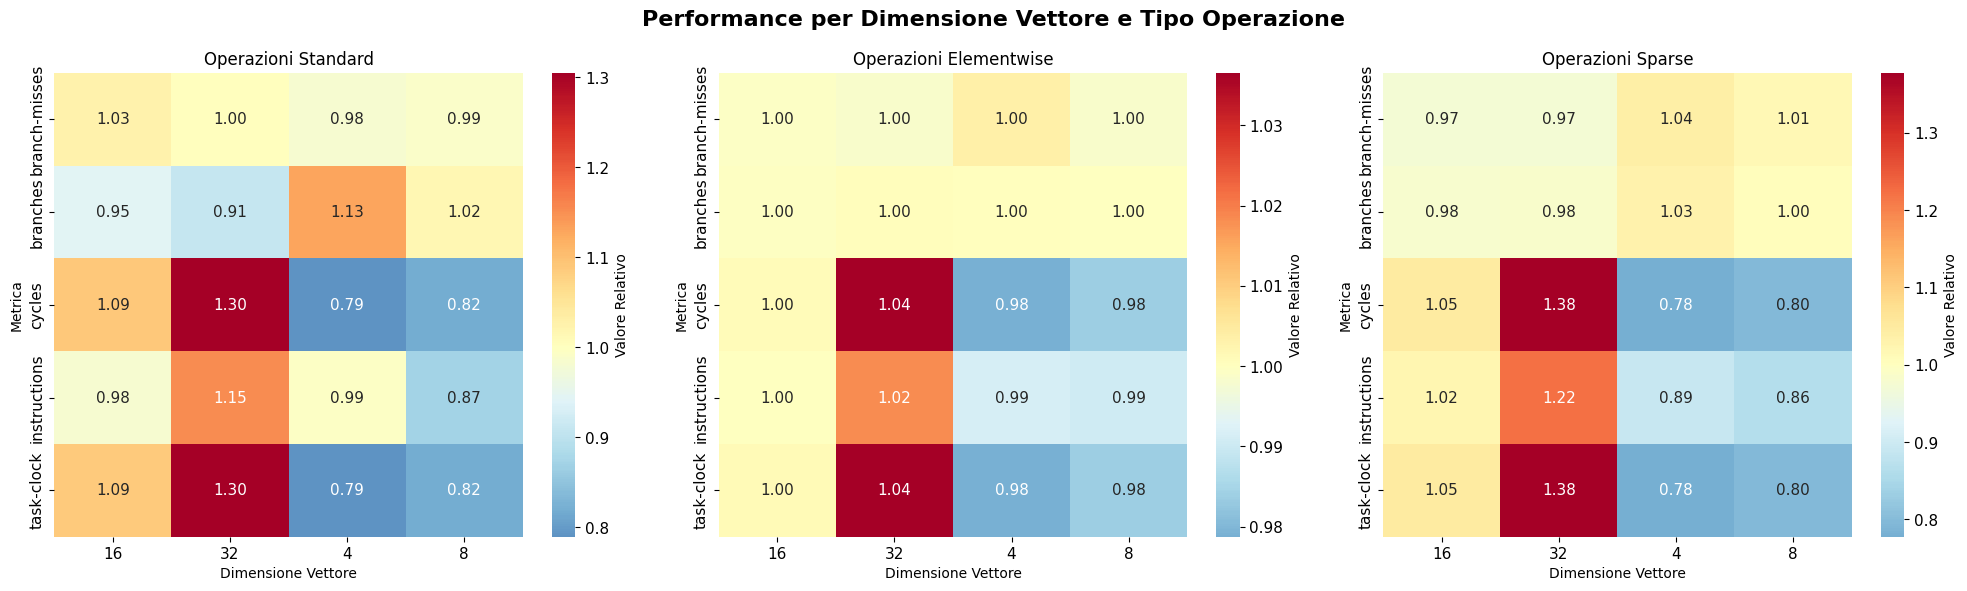


ANALISI SCALABILITÀ DIMENSIONI VETTORE

TASK-CLOCK:
  standard    : Size 4: 3.05e+00 | Size 8: 3.16e+00 | Size 16: 4.20e+00 | Size 32: 5.04e+00 |
  elementwise : Size 4: 2.05e+00 | Size 8: 2.06e+00 | Size 16: 2.09e+00 | Size 32: 2.17e+00 |
  sparse      : Size 4: 2.56e+00 | Size 8: 2.62e+00 | Size 16: 3.45e+00 | Size 32: 4.53e+00 |

CYCLES:
  standard    : Size 4: 5.47e+06 | Size 8: 5.67e+06 | Size 16: 7.54e+06 | Size 32: 9.05e+06 |
  elementwise : Size 4: 3.67e+06 | Size 8: 3.68e+06 | Size 16: 3.75e+06 | Size 32: 3.88e+06 |
  sparse      : Size 4: 4.59e+06 | Size 8: 4.70e+06 | Size 16: 6.18e+06 | Size 32: 8.13e+06 |

INSTRUCTIONS:
  standard    : Size 4: 1.40e+06 | Size 8: 1.23e+06 | Size 16: 1.38e+06 | Size 32: 1.62e+06 |
  elementwise : Size 4: 9.88e+05 | Size 8: 9.87e+05 | Size 16: 9.97e+05 | Size 32: 1.02e+06 |
  sparse      : Size 4: 1.12e+06 | Size 8: 1.09e+06 | Size 16: 1.29e+06 | Size 32: 1.54e+06 |


In [106]:
# %% [markdown]
# ## 3. ANALISI PER DIMENSIONE VETTORE

# %%
def analyze_vector_dimensions():
    """
    Analizza le performance per diverse dimensioni di vettori
    """
    df_vector = df_metrics[df_metrics['test_type'] == 'vector'].copy()
    
    if df_vector.empty:
        print("Nessun dato vettoriale disponibile")
        return
    
    # Ordina le dimensioni
    vector_sizes = sorted([size for size in df_vector['vector_size'].unique() 
                          if size not in ['N/A', 'unknown']], 
                         key=lambda x: int(x) if x.isdigit() else 0)
    
    if not vector_sizes:
        print("Nessuna dimensione vettore valida trovata")
        return
    
    print(f"Dimensioni vettore analizzate: {vector_sizes}")
    
    # Crea heatmap per ogni tipo di operazione
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    fig.suptitle('Performance per Dimensione Vettore e Tipo Operazione', fontsize=16, fontweight='bold')
    
    for i, op_type in enumerate(['standard', 'elementwise', 'sparse']):
        if i >= len(axes):
            break
            
        op_data = df_vector[df_vector['operation_type'] == op_type]
        
        if not op_data.empty:
            # Crea matrice pivot per heatmap
            pivot_data = op_data.pivot_table(
                index='event', 
                columns='vector_size', 
                values='value_numeric',
                aggfunc='mean'
            )
            
            # Normalizza per riga per confronto relativo
            pivot_normalized = pivot_data.div(pivot_data.mean(axis=1), axis=0)
            
            sns.heatmap(pivot_normalized, annot=True, fmt='.2f', cmap='RdYlBu_r', 
                       center=1, ax=axes[i], cbar_kws={'label': 'Valore Relativo'})
            axes[i].set_title(f'Operazioni {op_type.title()}')
            axes[i].set_xlabel('Dimensione Vettore')
            axes[i].set_ylabel('Metrica')
    
    plt.tight_layout()
    plt.show()
    
    # Analisi della scalabilità
    print("\n" + "="*60)
    print("ANALISI SCALABILITÀ DIMENSIONI VETTORE")
    print("="*60)
    
    for metric in ['task-clock', 'cycles', 'instructions']:
        if metric not in available_metrics:
            continue
            
        print(f"\n{metric.upper()}:")
        
        for op_type in ['standard', 'elementwise', 'sparse']:
            op_data = df_vector[(df_vector['operation_type'] == op_type) & 
                               (df_vector['event'] == metric)]
            
            if not op_data.empty:
                print(f"  {op_type:12s}:", end="")
                for size in vector_sizes:
                    size_data = op_data[op_data['vector_size'] == size]['value_numeric']
                    if not size_data.empty:
                        mean_val = size_data.mean()
                        print(f" Size {size}: {mean_val:.2e}", end=" |")
                print()

# Esegui analisi dimensioni vettore
analyze_vector_dimensions()

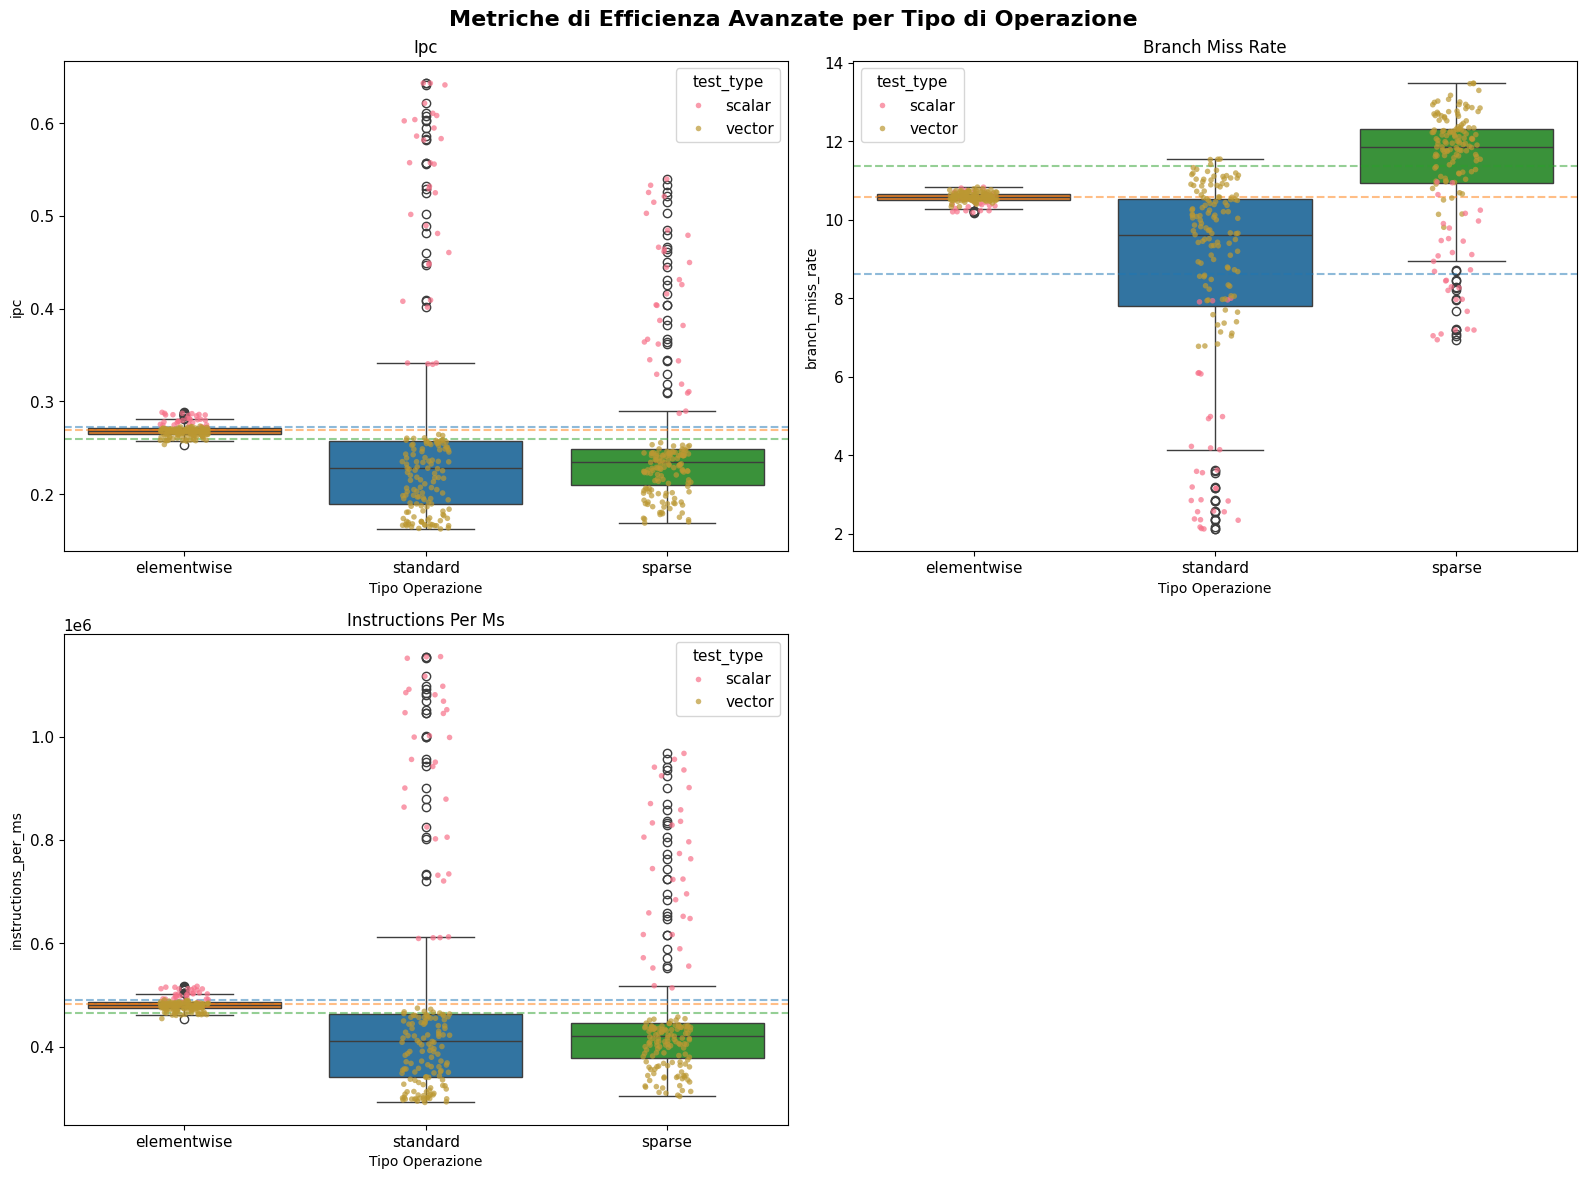

In [107]:
# %% [markdown]
# ## 4. METRICHE DI EFFICIENZA AVANZATE

# %%
def calculate_advanced_efficiency_metrics():
    """
    Calcola metriche di efficienza avanzate per ogni combinazione di test
    """
    efficiency_data = []
    
    # Raggruppa per test unico
    for test_group in df_metrics.groupby(['file_name', 'test_type', 'operation_type', 'vector_size']):
        group_key, group_data = test_group
        
        # Estrai valori metriche
        metrics_dict = {}
        for _, row in group_data.iterrows():
            metrics_dict[row['event']] = row['value_numeric']
        
        # Calcola metriche derivate
        efficiency_record = {
            'file_name': group_key[0],
            'test_type': group_key[1],
            'operation_type': group_key[2],
            'vector_size': group_key[3],
        }
        
        # IPC (Instructions Per Cycle)
        if 'cycles' in metrics_dict and 'instructions' in metrics_dict:
            cycles = metrics_dict['cycles']
            instructions = metrics_dict['instructions']
            efficiency_record['ipc'] = instructions / cycles if cycles > 0 else np.nan
            efficiency_record['cycles_per_instruction'] = cycles / instructions if instructions > 0 else np.nan
        
        # Branch prediction efficiency
        if 'branches' in metrics_dict and 'branch-misses' in metrics_dict:
            branches = metrics_dict['branches']
            branch_misses = metrics_dict['branch-misses']
            efficiency_record['branch_miss_rate'] = (branch_misses / branches * 100) if branches > 0 else np.nan
            efficiency_record['branch_accuracy'] = ((branches - branch_misses) / branches * 100) if branches > 0 else np.nan
        
        # Throughput metrics
        if 'task-clock' in metrics_dict:
            time_ms = metrics_dict['task-clock']
            if 'instructions' in metrics_dict:
                efficiency_record['instructions_per_ms'] = metrics_dict['instructions'] / time_ms if time_ms > 0 else np.nan
            if 'cycles' in metrics_dict:
                efficiency_record['cycles_per_ms'] = metrics_dict['cycles'] / time_ms if time_ms > 0 else np.nan
        
        # Cache efficiency (se disponibile)
        if 'cache-references' in metrics_dict and 'cache-misses' in metrics_dict:
            cache_refs = metrics_dict['cache-references']
            cache_misses = metrics_dict['cache-misses']
            efficiency_record['cache_miss_rate'] = (cache_misses / cache_refs * 100) if cache_refs > 0 else np.nan
            efficiency_record['cache_hit_rate'] = ((cache_refs - cache_misses) / cache_refs * 100) if cache_refs > 0 else np.nan
        
        efficiency_data.append(efficiency_record)
    
    df_efficiency = pd.DataFrame(efficiency_data)
    
    # Visualizza metriche di efficienza
    efficiency_metrics = ['ipc', 'branch_miss_rate', 'instructions_per_ms', 'cache_miss_rate']
    available_eff_metrics = [m for m in efficiency_metrics if m in df_efficiency.columns and not df_efficiency[m].isna().all()]
    
    if available_eff_metrics:
        n_metrics = len(available_eff_metrics)
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        axes = axes.flatten()
        fig.suptitle('Metriche di Efficienza Avanzate per Tipo di Operazione', fontsize=16, fontweight='bold')
        
        for i, metric in enumerate(available_eff_metrics[:4]):
            if i >= len(axes):
                break
                
            ax = axes[i]
            
            # Box plot per tipo di operazione
            metric_data = df_efficiency.dropna(subset=[metric])
            if not metric_data.empty:
                sns.boxplot(data=metric_data, x='operation_type', y=metric, 
                           palette=OPERATION_COLORS, ax=ax)
                
                # Aggiungi overlay dei punti per test type
                sns.stripplot(data=metric_data, x='operation_type', y=metric, 
                             hue='test_type', alpha=0.7, size=4, ax=ax)
                
                ax.set_title(f'{metric.replace("_", " ").title()}')
                ax.set_xlabel('Tipo Operazione')
                
                # Calcola e mostra statistiche
                for op_type in metric_data['operation_type'].unique():
                    values = metric_data[metric_data['operation_type'] == op_type][metric]
                    if not values.empty:
                        mean_val = values.mean()
                        ax.axhline(y=mean_val, color=OPERATION_COLORS.get(op_type, 'gray'), 
                                  linestyle='--', alpha=0.5)
        
        # Rimuovi subplot vuoti
        for i in range(len(available_eff_metrics), 4):
            if i < len(axes):
                axes[i].remove()
        
        plt.tight_layout()
        plt.show()
    
    return df_efficiency

# Calcola metriche di efficienza
df_efficiency = calculate_advanced_efficiency_metrics()

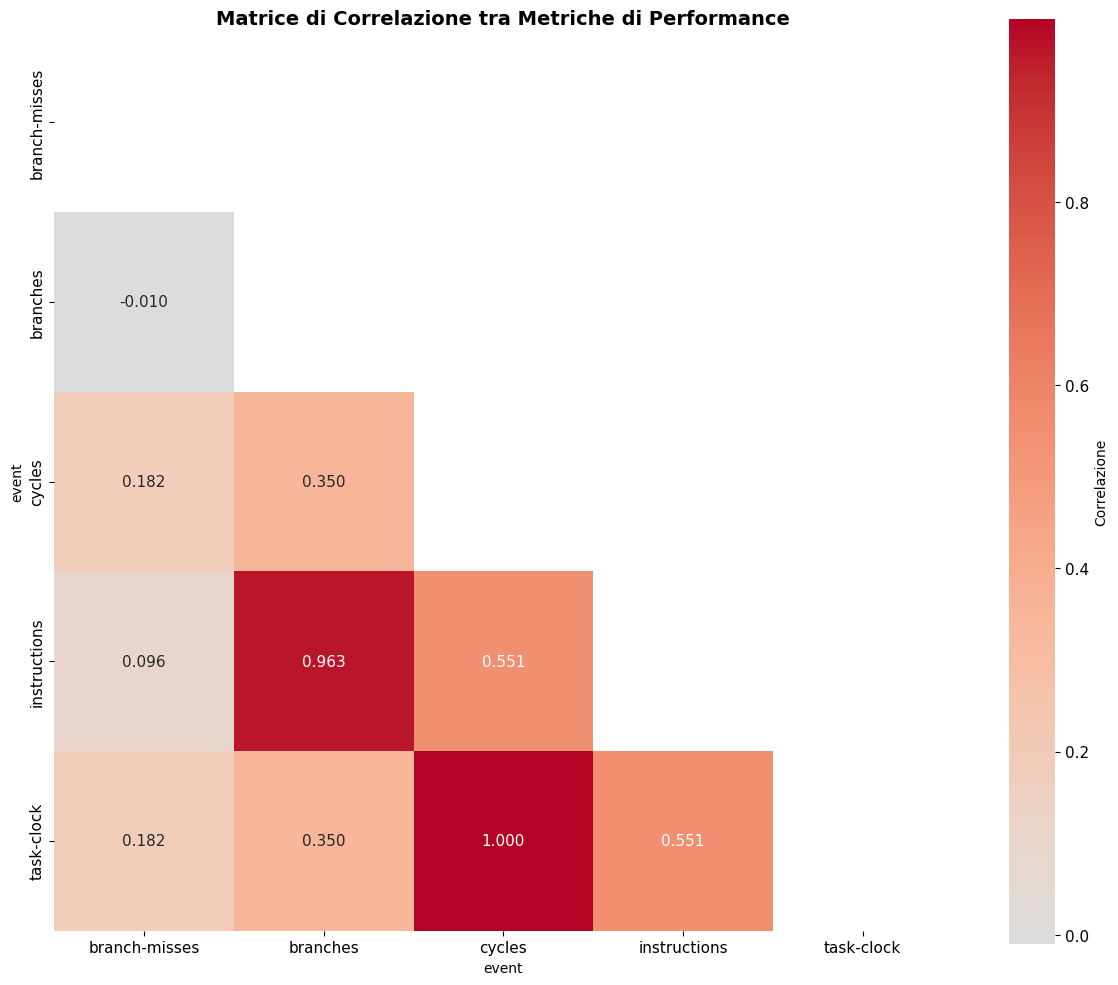

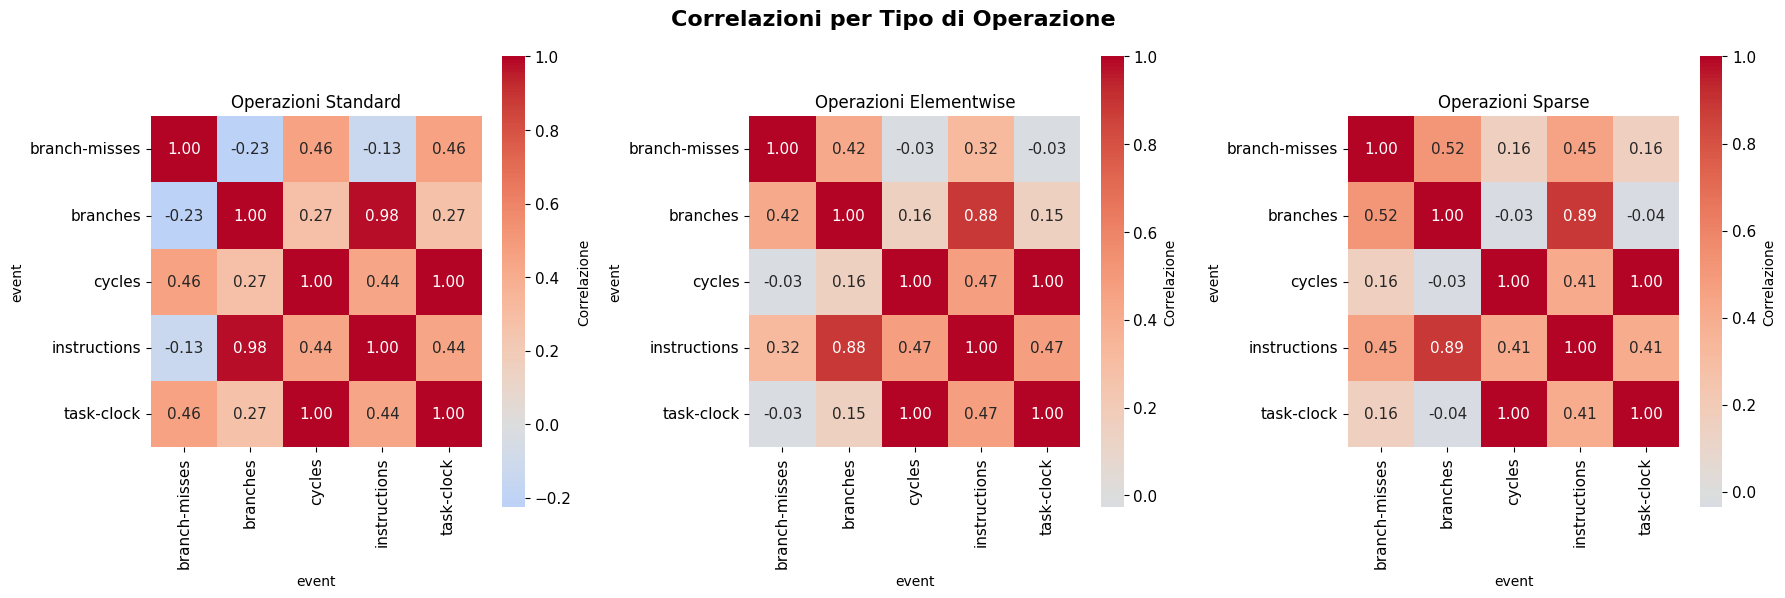

In [108]:
# %% [markdown]
# ## 5. ANALISI DI CORRELAZIONE AVANZATA

# %%
def create_correlation_analysis():
    """
    Crea analisi di correlazione avanzata tra metriche
    """
    # Prepara dati per correlazione
    pivot_data = df_metrics.pivot_table(
        index=['file_name', 'test_type', 'operation_type', 'vector_size'], 
        columns='event', 
        values='value_numeric',
        aggfunc='mean'
    ).reset_index()
    
    # Correlazione generale
    numeric_cols = [col for col in pivot_data.columns if col in available_metrics]
    if len(numeric_cols) >= 2:
        correlation_matrix = pivot_data[numeric_cols].corr()
        
        # Heatmap correlazione
        plt.figure(figsize=(12, 10))
        mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
        sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0, 
                    square=True, fmt='.3f', cbar_kws={'label': 'Correlazione'})
        plt.title('Matrice di Correlazione tra Metriche di Performance', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
    
    # Correlazione per tipo di operazione
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle('Correlazioni per Tipo di Operazione', fontsize=16, fontweight='bold')
    
    for i, op_type in enumerate(['standard', 'elementwise', 'sparse']):
        if i >= len(axes):
            break
            
        op_data = pivot_data[pivot_data['operation_type'] == op_type]
        
        if len(op_data) > 1 and len(numeric_cols) >= 2:
            op_corr = op_data[numeric_cols].corr()
            
            sns.heatmap(op_corr, annot=True, cmap='coolwarm', center=0, 
                       square=True, fmt='.2f', ax=axes[i],
                       cbar_kws={'label': 'Correlazione'})
            axes[i].set_title(f'Operazioni {op_type.title()}')
    
    plt.tight_layout()
    plt.show()

# Esegui analisi correlazione
create_correlation_analysis()

In [120]:
# %% [markdown]
# ## 6. PERFORMANCE RANKING E RACCOMANDAZIONI

# %%
def generate_performance_ranking():
    """
    Genera ranking delle performance e raccomandazioni
    """
    print("="*80)
    print("RANKING PERFORMANCE E RACCOMANDAZIONI")
    print("="*80)
    print(df_efficiency)

    # Ranking per tempo di esecuzione
    if 'task-clock' in available_metrics:
        time_data = df_metrics[df_metrics['event'] == 'task-clock'].groupby(
            ['operation_type', 'test_type', 'vector_size']
        )['value_numeric'].mean().reset_index()
        
        print("\nRANKING TEMPO DI ESECUZIONE (migliore = più veloce):")
        print("-" * 60)
        
        time_ranking = time_data.sort_values('value_numeric')
        for i, (_, row) in enumerate(time_ranking.head(10).iterrows(), 1):
            config = f"{row['test_type']}-{row['operation_type']}"
            if row['vector_size'] != 'N/A':
                config += f"-size{row['vector_size']}"
            print(f"{i:2d}. {config:25s}: {row['value_numeric']:8.3f} ms")
    
    # Ranking per efficienza istruzioni
    if not df_efficiency.empty and 'ipc' in df_efficiency.columns:
        ipc_data = df_efficiency.dropna(subset=['ipc']).groupby(
            ['operation_type', 'test_type', 'vector_size']
        )['ipc'].mean().reset_index()
        
        print(f"\nRANKING EFFICIENZA IPC (migliore = più alto):")
        print("-" * 60)
        
        ipc_ranking = ipc_data.sort_values('ipc', ascending=False)
        for i, (_, row) in enumerate(ipc_ranking.head(10).iterrows(), 1):
            config = f"{row['test_type']}-{row['operation_type']}"
            if row['vector_size'] != 'N/A':
                config += f"-size{row['vector_size']}"
            print(f"{i:2d}. {config:25s}: {row['ipc']:8.3f} IPC")
    
    # Raccomandazioni basate sui dati
    print("-" * 60)
    
    # Raccomandazione per tipo di operazione
    if 'task-clock' in available_metrics:
        op_performance = df_metrics[df_metrics['event'] == 'task-clock'].groupby('operation_type')['value_numeric'].mean()
        best_operation = op_performance.idxmin()
        worst_operation = op_performance.idxmax()
        
        improvement = ((op_performance[worst_operation] - op_performance[best_operation]) / op_performance[worst_operation]) * 100
        
        print(f"1. Tipo operazione ottimale: '{best_operation.upper()}'")
        print(f"   - {improvement:.1f}% più veloce rispetto a '{worst_operation}'")
    
    # Raccomandazione per dimensione vettore
    if 'task-clock' in available_metrics:
        vector_data = df_metrics[(df_metrics['event'] == 'task-clock') & (df_metrics['test_type'] == 'vector')]
        if not vector_data.empty:
            size_performance = vector_data.groupby('vector_size')['value_numeric'].mean()
        valid_sizes = [size for size in size_performance.index if size not in ['N/A', 'unknown']]
        
        if valid_sizes:
            # Ordina per performance (tempo minore = migliore)
            size_performance_valid = size_performance[valid_sizes].sort_values()
            best_size = size_performance_valid.index[0]
            worst_size = size_performance_valid.index[-1]
            
            size_improvement = ((size_performance_valid[worst_size] - size_performance_valid[best_size]) / size_performance_valid[worst_size]) * 100
            
            print(f"2. Dimensione vettore ottimale: Size {best_size}")
            print(f"   - {size_improvement:.1f}% più veloce rispetto a Size {worst_size}")
    
    # Raccomandazione per cache efficiency
    if not df_efficiency.empty and 'cache_miss_rate' in df_efficiency.columns:
        cache_data = df_efficiency.dropna(subset=['cache_miss_rate'])
        if not cache_data.empty:
            best_cache_op = cache_data.loc[cache_data['cache_miss_rate'].idxmin(), 'operation_type']
            best_cache_rate = cache_data['cache_miss_rate'].min()
            
            print(f"3. Migliore efficienza cache: '{best_cache_op.upper()}'")
            print(f"   - Cache miss rate: {best_cache_rate:.2f}%")
    
    # Raccomandazione per branch prediction
    if not df_efficiency.empty and 'branch_miss_rate' in df_efficiency.columns:
        branch_data = df_efficiency.dropna(subset=['branch_miss_rate'])
        if not branch_data.empty:
            best_branch_op = branch_data.loc[branch_data['branch_miss_rate'].idxmin(), 'operation_type']
            best_branch_rate = branch_data['branch_miss_rate'].min()
            
            print(f"4. Migliore branch prediction: '{best_branch_op.upper()}'")
            print(f"   - Branch miss rate: {best_branch_rate:.2f}%")


# Esegui ranking e raccomandazioni
generate_performance_ranking()

RANKING PERFORMANCE E RACCOMANDAZIONI
              file_name test_type operation_type vector_size       ipc  \
0      elementwise_50_1    scalar    elementwise         N/A  0.287184   
1      elementwise_50_2    scalar    elementwise         N/A  0.288279   
2      elementwise_50_3    scalar    elementwise         N/A  0.287255   
3      elementwise_55_1    scalar    elementwise         N/A  0.286006   
4      elementwise_55_2    scalar    elementwise         N/A  0.284521   
..                  ...       ...            ...         ...       ...   
460  sparse_sparse_90_3    scalar         sparse         N/A  0.329298   
461  sparse_sparse_95_1    scalar         sparse         N/A  0.287239   
462  sparse_sparse_95_2    scalar         sparse         N/A  0.309067   
463  sparse_sparse_95_3    scalar         sparse         N/A  0.289607   
464  sparse_sparse_95_4    scalar         sparse         N/A  0.318667   

     cycles_per_instruction  branch_miss_rate  branch_accuracy  \
0      

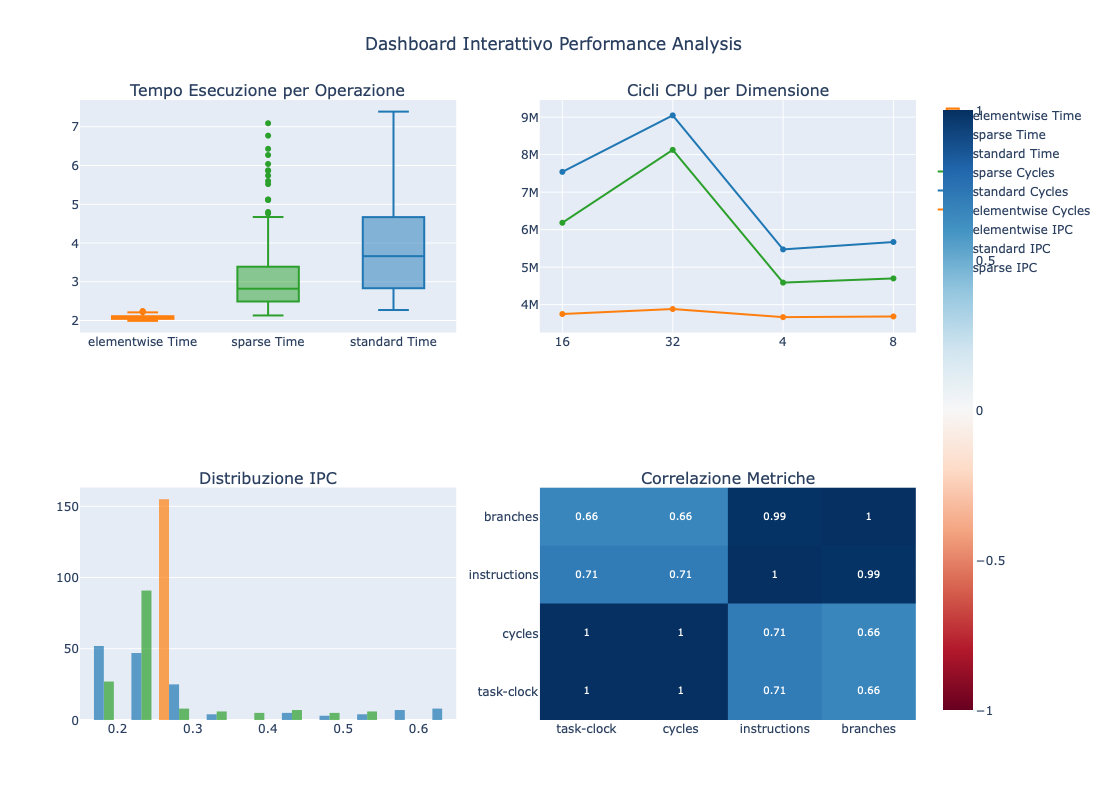

In [112]:
# %% [markdown]
# ## 7. GRAFICI INTERATTIVI CON PLOTLY

# %%
def create_interactive_dashboard():
    """
    Crea dashboard interattivo con Plotly per esplorazione avanzata
    """
    if df_metrics.empty:
        print("Nessun dato disponibile per dashboard interattivo")
        return
    
    # Dashboard multi-metrica
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=('Tempo Esecuzione per Operazione', 'Cicli CPU per Dimensione', 
                       'Distribuzione IPC', 'Correlazione Metriche'),
        specs=[[{"secondary_y": False}, {"secondary_y": False}],
               [{"secondary_y": False}, {"secondary_y": False}]]
    )
    
    # Grafico 1: Tempo di esecuzione
    if 'task-clock' in available_metrics:
        time_data = df_metrics[df_metrics['event'] == 'task-clock']
        
        for op_type in time_data['operation_type'].unique():
            op_data = time_data[time_data['operation_type'] == op_type]
            fig.add_trace(
                go.Box(y=op_data['value_numeric'], name=f'{op_type} Time',
                      marker_color=OPERATION_COLORS.get(op_type, 'gray'),
                      showlegend=True),
                row=1, col=1
            )
    
    # Grafico 2: Cicli per dimensione vettore
    if 'cycles' in available_metrics:
        cycles_data = df_metrics[(df_metrics['event'] == 'cycles') & (df_metrics['test_type'] == 'vector')]
        for op_type in cycles_data['operation_type'].unique():
            op_data = cycles_data[cycles_data['operation_type'] == op_type]
            if not op_data.empty:
                # Raggruppa per dimensione e ordina per vector_size
                size_means = op_data.groupby('vector_size')['value_numeric'].mean().reset_index()
                # Converti vector_size in numerico e ordina
                size_means = size_means.sort_values('vector_size')
                
                fig.add_trace(
                    go.Scatter(x=size_means['vector_size'], 
                              y=size_means['value_numeric'],
                              mode='lines+markers',
                              name=f'{op_type} Cycles',
                              line=dict(color=OPERATION_COLORS.get(op_type, 'gray'))),
                    row=1, col=2
                )
    
    # Grafico 3: Distribuzione IPC
    if not df_efficiency.empty and 'ipc' in df_efficiency.columns:
        ipc_data = df_efficiency.dropna(subset=['ipc'])
        
        for op_type in ipc_data['operation_type'].unique():
            op_ipc = ipc_data[ipc_data['operation_type'] == op_type]['ipc']
            fig.add_trace(
                go.Histogram(x=op_ipc, name=f'{op_type} IPC', 
                           opacity=0.7, nbinsx=15,
                           marker_color=OPERATION_COLORS.get(op_type, 'gray')),
                row=2, col=1
            )
    
    # Grafico 4: Heatmap correlazione (semplificata)
    if len(available_metrics) >= 2:
        pivot_data = df_metrics.pivot_table(
            index=['file_name'], columns='event', values='value_numeric', aggfunc='mean'
        )
        
        if not pivot_data.empty:
            corr_matrix = pivot_data[available_metrics[:4]].corr()  # Prime 4 metriche
            
            fig.add_trace(
                go.Heatmap(z=corr_matrix.values, 
                          x=corr_matrix.columns, 
                          y=corr_matrix.index,
                          colorscale='RdBu', zmid=0,
                          text=corr_matrix.round(2).values,
                          texttemplate="%{text}", textfont={"size":10}),
                row=2, col=2
            )
    
    # Aggiorna layout
    fig.update_layout(
        height=800, 
        title_text="Dashboard Interattivo Performance Analysis",
        title_x=0.5,
        showlegend=True
    )
    
    fig.show()



# Crea dashboard interattivo
create_interactive_dashboard()



In [113]:
# Grafico separato: IPC per Sparsità e Tipo di Operazione
def create_ipc_sparsity_plot():
    """
    Crea grafico IPC separato per sparsità e tipo di operazione
    """
    try:
        if df_efficiency.empty or 'ipc' not in df_efficiency.columns:
            print("Dati IPC non disponibili o dataframe vuoto")
            return
            
        ipc_data = df_efficiency.dropna(subset=['ipc'])

        print(ipc_data)
        if 'sparsity' not in ipc_data.columns or 'operation_type' not in ipc_data.columns:
            print("Colonne 'sparsity' o 'operation_type' mancanti")
            return
            
        # Calcola medie per sparsità e operazione
        ipc_means = ipc_data.groupby(['sparsity', 'operation_type'])['ipc'].mean().reset_index()
        
        fig_bar = go.Figure()
        
        sparsity_levels = sorted(ipc_means['sparsity'].unique())
        
        for sparsity in sparsity_levels:
            sparsity_means = ipc_means[ipc_means['sparsity'] == sparsity]
            
            fig_bar.add_trace(
                go.Bar(
                    x=sparsity_means['operation_type'],
                    y=sparsity_means['ipc'],
                    name=f'Sparsità {sparsity}%',
                    text=[f'{val:.2f}' for val in sparsity_means['ipc']],
                    textposition='auto'
                )
            )
        
        fig_bar.update_layout(
            title='IPC Medio per Sparsità e Tipo di Operazione',
            xaxis_title='Tipo di Operazione',
            yaxis_title='IPC Medio',
            barmode='group',
            height=500
        )
        
        fig_bar.show()  # This is the fix - added parentheses to call the method
        
    except Exception as e:
        print(f"Errore durante la creazione del grafico: {str(e)}")

# Crea grafico IPC per sparsità
create_ipc_sparsity_plot()

              file_name test_type operation_type vector_size       ipc  \
0      elementwise_50_1    scalar    elementwise         N/A  0.287184   
1      elementwise_50_2    scalar    elementwise         N/A  0.288279   
2      elementwise_50_3    scalar    elementwise         N/A  0.287255   
3      elementwise_55_1    scalar    elementwise         N/A  0.286006   
4      elementwise_55_2    scalar    elementwise         N/A  0.284521   
..                  ...       ...            ...         ...       ...   
460  sparse_sparse_90_3    scalar         sparse         N/A  0.329298   
461  sparse_sparse_95_1    scalar         sparse         N/A  0.287239   
462  sparse_sparse_95_2    scalar         sparse         N/A  0.309067   
463  sparse_sparse_95_3    scalar         sparse         N/A  0.289607   
464  sparse_sparse_95_4    scalar         sparse         N/A  0.318667   

     cycles_per_instruction  branch_miss_rate  branch_accuracy  \
0                  3.482084         10.235373

In [ ]:
# %% [markdown]
# ## 8. EXPORT RISULTATI E SUMMARY FINALE

# %%
def export_analysis_results():
    """
    Esporta risultati dell'analisi in formati utilizzabili
    """
    print("="*80)
    print("EXPORT RISULTATI ANALISI")
    print("="*80)
    
    # Crea cartella per export se non esistente
    output_dir = Path("analysis_results")
    output_dir.mkdir(exist_ok=True)
    
    # 1. Export dataset principale
    if not df_metrics.empty:
        df_metrics.to_csv(output_dir / "performance_metrics_cleaned.csv", index=False)
        print(f"✅ Dataset metriche esportato: {len(df_metrics)} record")
    
    # 2. Export metriche di efficienza
    if not df_efficiency.empty:
        df_efficiency.to_csv(output_dir / "efficiency_metrics.csv", index=False)
        print(f"✅ Metriche efficienza esportate: {len(df_efficiency)} record")
    
    # 3. Export summary statistiche
    summary_stats = []
    
    for metric in available_metrics:
        metric_data = df_metrics[df_metrics['event'] == metric]
        
        for op_type in metric_data['operation_type'].unique():
            op_data = metric_data[metric_data['operation_type'] == op_type]['value_numeric']
            
            if not op_data.empty:
                summary_stats.append({
                    'metric': metric,
                    'operation_type': op_type,
                    'count': len(op_data),
                    'mean': op_data.mean(),
                    'std': op_data.std(),
                    'min': op_data.min(),
                    'max': op_data.max(),
                    'median': op_data.median(),
                    'q25': op_data.quantile(0.25),
                    'q75': op_data.quantile(0.75)
                })
    
    if summary_stats:
        pd.DataFrame(summary_stats).to_csv(output_dir / "summary_statistics.csv", index=False)
        print(f"✅ Statistiche riassuntive esportate")
    
    # 4. Export best configurations
    best_configs = []
    
    if 'task-clock' in available_metrics:
        time_data = df_metrics[df_metrics['event'] == 'task-clock']
        best_time = time_data.loc[time_data['value_numeric'].idxmin()]
        best_configs.append({
            'metric': 'best_execution_time',
            'configuration': f"{best_time['test_type']}-{best_time['operation_type']}-{best_time['vector_size']}",
            'value': best_time['value_numeric'],
            'unit': 'ms'
        })
    
    if not df_efficiency.empty and 'ipc' in df_efficiency.columns:
        ipc_data = df_efficiency.dropna(subset=['ipc'])
        if not ipc_data.empty:
            best_ipc = ipc_data.loc[ipc_data['ipc'].idxmax()]
            best_configs.append({
                'metric': 'best_ipc',
                'configuration': f"{best_ipc['test_type']}-{best_ipc['operation_type']}-{best_ipc['vector_size']}",
                'value': best_ipc['ipc'],
                'unit': 'instructions/cycle'
            })
    
    if best_configs:
        pd.DataFrame(best_configs).to_csv(output_dir / "best_configurations.csv", index=False)
        print(f"✅ Configurazioni ottimali esportate")
    
    print(f"\n📁 Tutti i file esportati in: {output_dir.absolute()}")

def generate_final_summary():
    """
    Genera summary finale dell'analisi
    """
    print("\n" + "="*80)
    print("SUMMARY FINALE DELL'ANALISI")
    print("="*80)
    
    print("\n📊 DATASET ANALIZZATO:")
    print(f"   • File processati: {df['file_name'].nunique()}")
    print(f"   • Record totali: {len(df)}")
    print(f"   • Metriche principali: {len(available_metrics)}")
    print(f"   • Tipi operazione: {', '.join(df['operation_type'].unique())}")
    print(f"   • Dimensioni vettore: {', '.join(sorted([s for s in df['vector_size'].unique() if s not in ['N/A', 'unknown']]))}")
    
    # Migliori performance per categoria
    print(f"\n🏆 PERFORMANCE HIGHLIGHTS:")
    
    if 'task-clock' in available_metrics:
        fastest_overall = df_metrics[df_metrics['event'] == 'task-clock'].loc[
            df_metrics[df_metrics['event'] == 'task-clock']['value_numeric'].idxmin()
        ]
        print(f"   • Configurazione più veloce:")
        print(f"     {fastest_overall['test_type']}-{fastest_overall['operation_type']} (Size: {fastest_overall['vector_size']}) = {fastest_overall['value_numeric']:.3f} ms")
    
    if not df_efficiency.empty and 'ipc' in df_efficiency.columns:
        best_efficiency = df_efficiency.loc[df_efficiency['ipc'].idxmax()]
        print(f"   • Migliore efficienza IPC:")
        print(f"     {best_efficiency['test_type']}-{best_efficiency['operation_type']} (Size: {best_efficiency['vector_size']}) = {best_efficiency['ipc']:.3f} IPC")
    
    # Insights principali
    print(f"\n💡 INSIGHTS CHIAVE:")
    
    # Confronto scalar vs vector
    if 'task-clock' in available_metrics:
        scalar_time = df_metrics[(df_metrics['event'] == 'task-clock') & (df_metrics['test_type'] == 'scalar')]['value_numeric'].mean()
        vector_time = df_metrics[(df_metrics['event'] == 'task-clock') & (df_metrics['test_type'] == 'vector')]['value_numeric'].mean()
        
        if not pd.isna(scalar_time) and not pd.isna(vector_time):
            speedup = scalar_time / vector_time if vector_time > 0 else np.nan
            if not pd.isna(speedup):
                print(f"   • Speedup medio vector vs scalar: {speedup:.2f}x")
    
    # Migliore tipo di operazione
    if 'task-clock' in available_metrics:
        op_times = df_metrics[df_metrics['event'] == 'task-clock'].groupby('operation_type')['value_numeric'].mean()
        if not op_times.empty:
            best_op = op_times.idxmin()
            worst_op = op_times.idxmax()
            improvement = ((op_times[worst_op] - op_times[best_op]) / op_times[worst_op]) * 100
            print(f"   • Operazione più efficiente: {best_op} ({improvement:.1f}% migliore di {worst_op})")
    
    # Tendenza scalabilità
    vector_data = df_metrics[(df_metrics['test_type'] == 'vector') & (df_metrics['event'] == 'task-clock')]
    if not vector_data.empty:
        size_performance = vector_data.groupby('vector_size')['value_numeric'].mean()
        valid_sizes = [s for s in size_performance.index if s not in ['N/A', 'unknown'] and s.isdigit()]
        
        if len(valid_sizes) >= 2:
            # Ordina numericamente
            valid_sizes_sorted = sorted(valid_sizes, key=int)
            trend = "crescente" if size_performance[valid_sizes_sorted[-1]] > size_performance[valid_sizes_sorted[0]] else "decrescente"
            print(f"   • Trend scalabilità dimensioni: {trend}")
    
    
    print("="*80)

# Esegui export e summary finale
export_analysis_results()
generate_final_summary()
